## WSI Level Classification on BACH Part B (WSIs)
### Specs:
- Efficient net b0
- Auto-Encoder
- Self Attention
- 20 epochs, lr=0.000025
- Classes = 'Benign or Insitu Carcinoma', 'Invasive Carcinoma'
- Pos_weight = 0.6 (invasive carcinoma)

In [9]:
# importing necessary libraries 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision 
from torchvision import transforms, datasets, models 
from torch.nn import functional as F 
from PIL import Image
import pandas as pd 
import numpy as np
import tensorflow as tf
import os
import sys
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
import cv2
import json 
from tqdm import tqdm
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from skimage.transform import rotate, AffineTransform
import random
from scipy import ndimage
import openslide
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import xml.etree.ElementTree as ET 
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import defaultdict
# Setting random seed for reproducibility
torch.manual_seed(42)

In [10]:
import numpy as np
from sklearn.model_selection import GroupKFold
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

# Dummy data with WSI numbers as strings
# WSI IDs (10 WSIs with 1-3 bags each)
example_wsi_ids = np.array(['A01', 'A01', 'A02', 'A02', 'A03', 'A03', 'A04', 'A04', 'A05', 
                            'A06', 'A06', 'A07', 'A08', 'A09', 'A10'])

# Dummy bags data (15 bags, each with 50 patches and num_features_n features)
example_bags = np.random.rand(15, 50, num_features_n)

# Dummy labels (binary classification: 0 or 1)
example_labels = np.random.randint(0, 2, 15)

# Define a basic CustomDataset class
class CustomDataset(Dataset):
    def __init__(self, bags, labels):
        self.bags = bags
        self.labels = labels

    def __len__(self):
        return len(self.bags)

    def __getitem__(self, idx):
        bag = torch.tensor(self.bags[idx]).float()
        label = torch.tensor(self.labels[idx])
        return bag, label

# Number of folds for cross-validation
num_folds = 3
group_kfold = GroupKFold(n_splits=num_folds)
batch_size = 4  # Example batch size

# Run GroupKFold split
for fold, (train_idx, test_idx) in enumerate(group_kfold.split(example_bags, example_labels, groups=example_wsi_ids)):
    # Splitting bags and labels for each fold
    train_bags, test_bags = example_bags[train_idx], example_bags[test_idx]
    train_labels, test_labels = example_labels[train_idx], example_labels[test_idx]

    # Creating datasets and loaders for each fold
    train_dataset = CustomDataset(train_bags, train_labels)
    test_dataset = CustomDataset(test_bags, test_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Output the fold details
    print(f"\nFold {fold + 1}")
    print(f"Train WSI IDs: {example_wsi_ids[train_idx]}")
    print(f"Test WSI IDs: {example_wsi_ids[test_idx]}")
    print(f"Train size: {len(train_loader.dataset)}, Test size: {len(test_loader.dataset)}")



Fold 1
Train WSI IDs: ['A01' 'A01' 'A03' 'A03' 'A06' 'A06' 'A07' 'A08' 'A09' 'A10']
Test WSI IDs: ['A02' 'A02' 'A04' 'A04' 'A05']
Train size: 10, Test size: 5

Fold 2
Train WSI IDs: ['A01' 'A01' 'A02' 'A02' 'A04' 'A04' 'A05' 'A07' 'A09' 'A10']
Test WSI IDs: ['A03' 'A03' 'A06' 'A06' 'A08']
Train size: 10, Test size: 5

Fold 3
Train WSI IDs: ['A02' 'A02' 'A03' 'A03' 'A04' 'A04' 'A05' 'A06' 'A06' 'A08']
Test WSI IDs: ['A01' 'A01' 'A07' 'A09' 'A10']
Train size: 10, Test size: 5


**LOADING PATCH EMBEDDINGS** 

In [11]:
patch_features = torch.load('/kaggle/input/bach-dataset-patches/Patch Info (25 overlap)/Patch Info (25% overlap)/patch_embeddings.pth') 

/tmp/ipykernel_30/2151156794.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch_features = torch.load('/kaggle/input/bach-dataset-patches/Patch Info (25 overlap)/Patc

In [52]:
num_features_n=300

In [53]:
# Defining Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
           nn.Linear(input_size, 16),
           nn.ReLU(),
           nn.Linear(16, encoding_dim),
           nn.ReLU()
        )
        self.decoder = nn.Sequential(
           nn.Linear(encoding_dim, 16),
           nn.ReLU(),
           nn.Linear(16, input_size),
           nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
# Combining feature maps for PCA 


scaler = StandardScaler()
X_scaled = scaler.fit_transform(patch_features)

X_tensor = torch.FloatTensor(X_scaled)

input_size = 1000  # Number of input features
encoding_dim = num_features_n  # Desired number of output dimensions
model = Autoencoder(input_size, encoding_dim)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

# Training the autoencoder
num_epochs = 20
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs, X_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [1/20], Loss: 1.2517
Epoch [2/20], Loss: 1.2514
Epoch [3/20], Loss: 1.2509
Epoch [4/20], Loss: 1.2505
Epoch [5/20], Loss: 1.2500
Epoch [6/20], Loss: 1.2495
Epoch [7/20], Loss: 1.2490
Epoch [8/20], Loss: 1.2483
Epoch [9/20], Loss: 1.2477
Epoch [10/20], Loss: 1.2470
Epoch [11/20], Loss: 1.2462
Epoch [12/20], Loss: 1.2454
Epoch [13/20], Loss: 1.2446
Epoch [14/20], Loss: 1.2437
Epoch [15/20], Loss: 1.2428
Epoch [16/20], Loss: 1.2419
Epoch [17/20], Loss: 1.2410
Epoch [18/20], Loss: 1.2400
Epoch [19/20], Loss: 1.2391
Epoch [20/20], Loss: 1.2381


In [54]:
# Encoding the data using the trained autoencoder
encoded_features = model.encoder(X_tensor).detach().numpy()

**LOADING PATCH DATA** 

In [55]:
# reading patients' data 

df = pd.read_csv('/kaggle/input/bach-dataset-patches/Patch Info (25 overlap)/Patch Info (25% overlap)/patch_info.csv')

# Rename specific values in the 'Label' column
df['Label'] = df['Label'].replace({
    'Carcinoma invasive': 'Invasive carcinoma',
    'Carcinoma in situ': 'In situ carcinoma'
})
df.dropna(inplace = True)
df.head() 

,WSI Id,Annotation No.,X Start Pixel,Y Start Pixel,White Area %,Label
0,A01,1.0,7332.0,21574.0,18.018575,Benign
1,A01,1.0,7500.0,21574.0,23.828125,Benign
2,A01,1.0,7668.0,21574.0,23.170440,Benign
3,A01,1.0,7836.0,21574.0,20.073342,Benign
4,A01,1.0,7332.0,21742.0,20.615434,Benign


<Axes: xlabel='Label'>

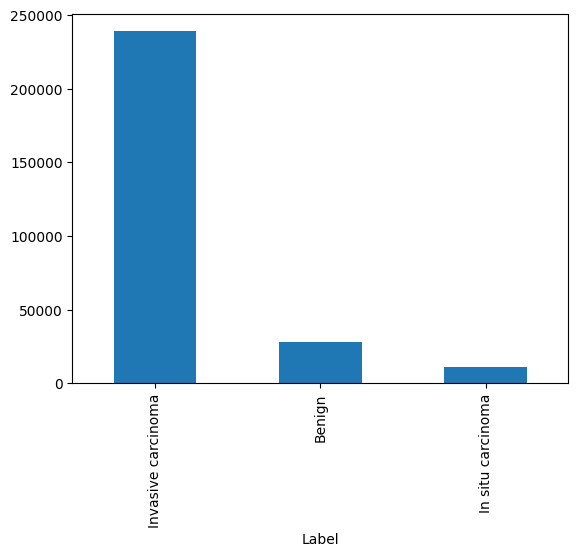

In [56]:
df['Label'].value_counts().plot.bar()

In [57]:
# filtering out excessively white patches 

#df = df[df['White Area %'] < 90] 

In [58]:
# filtering out first 5 WSIs for train, next 2 for validation, and the last 3 for test datasets 

train_df = df[(df['WSI Id'] == 'A01') | (df['WSI Id'] == 'A02') | (df['WSI Id'] == 'A03') | (df['WSI Id'] == 'A04') | (df['WSI Id'] == 'A05')].reset_index(drop=True)
mask = (df['WSI Id'] == 'A01') | (df['WSI Id'] == 'A02') | (df['WSI Id'] == 'A03') | (df['WSI Id'] == 'A04') | (df['WSI Id'] == 'A05') 
encoded_feats_train = [encoded_features[i] for i in range(len(encoded_features)) if mask.iloc[i]] 

val_df = df[(df['WSI Id'] == 'A06') | (df['WSI Id'] == 'A07')].reset_index(drop=True)
mask = (df['WSI Id'] == 'A06') | (df['WSI Id'] == 'A07') 
encoded_feats_val = [encoded_features[i] for i in range(len(encoded_features)) if mask.iloc[i]]

test_df = df[(df['WSI Id'] == 'A08') | (df['WSI Id'] == 'A09') | (df['WSI Id'] == 'A10')].reset_index(drop=True)
mask = (df['WSI Id'] == 'A08') | (df['WSI Id'] == 'A09') | (df['WSI Id'] == 'A10') 
encoded_feats_test = [encoded_features[i] for i in range(len(encoded_features)) if mask.iloc[i]]

In [59]:
# obtaining patient ids / wsi nos, annotation nos. & and labels 

train_wsi_nos = list(train_df['WSI Id']) 
train_ann_nos = list(train_df['Annotation No.']) 
train_labels = list(train_df['Label']) 

train_wsi_nos.extend(list(val_df['WSI Id']))
train_ann_nos.extend(list(val_df['Annotation No.']))
train_labels.extend(list(val_df['Label']))

train_wsi_nos.extend(list(test_df['WSI Id']))
train_ann_nos.extend(list(test_df['Annotation No.']))
train_labels.extend(list(test_df['Label'])) 

**LOADING EXTRA NORMAL PATCH EMBEDDINGS** 

In [60]:
norm_patch_feats = torch.load('/kaggle/input/bach-dataset-patches/Extra Normal Region (25 overlap)/Extra Normal Region (25% overlap)/patch_embeddings.pth') 

/tmp/ipykernel_30/1623961582.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  norm_patch_feats = torch.load('/kaggle/input/bach-dataset-patches/Extra Normal Region (25 ov

In [61]:
# applying auto encoder 
X_scaled_norm = scaler.transform(norm_patch_feats)

X_tensor_norm = torch.FloatTensor(X_scaled_norm)
norm_encoded_features = model.encoder(X_tensor_norm).detach().numpy()

**LOADING EXTRA NORMAL REGION DATA** 

In [62]:
# reading patients' data 

norm_df = pd.read_csv('/kaggle/input/bach-dataset-patches/Extra Normal Region (25 overlap)/Extra Normal Region (25% overlap)/patch_info.csv')
norm_df.dropna(inplace = True)
norm_df.head() 

,WSI Id,Annotation No.,X Start Pixel,Y Start Pixel,White Area %,Label
0,A01,1,33571,2449,59.221540,Normal
1,A01,1,33739,2449,57.029257,Normal
2,A01,1,33907,2449,74.382175,Normal
3,A01,1,34075,2449,87.559790,Normal
4,A01,1,34243,2449,89.349490,Normal


In [63]:
# dictionary containing current annotation counts for WSIs 

curr_ann_count = { 'A01': 40, 'A02': 17, 'A03': 10, 'A04': 1, 
                'A05': 15, 'A06': 6, 'A07': 7, 'A08': 92, 'A09': 29, 'A10': 9 } 

In [64]:
# updating the 'Annotation No.' column by adding the corresponding value from the dictionary 

norm_df['Annotation No.'] = norm_df.apply(
    lambda row: row['Annotation No.'] + curr_ann_count.get(row['WSI Id'], 0), axis=1
) 

norm_df.head() 

,WSI Id,Annotation No.,X Start Pixel,Y Start Pixel,White Area %,Label
0,A01,41,33571,2449,59.221540,Normal
1,A01,41,33739,2449,57.029257,Normal
2,A01,41,33907,2449,74.382175,Normal
3,A01,41,34075,2449,87.559790,Normal
4,A01,41,34243,2449,89.349490,Normal


In [65]:
# filtering out first 5 WSIs for train, next 2 for validation, and the last 3 for test datasets 

norm_train_df = norm_df[(norm_df['WSI Id'] == 'A01') | (norm_df['WSI Id'] == 'A02') | (norm_df['WSI Id'] == 'A03') | (norm_df['WSI Id'] == 'A04') | (norm_df['WSI Id'] == 'A05')].reset_index(drop=True)
mask = (norm_df['WSI Id'] == 'A01') | (norm_df['WSI Id'] == 'A02') | (norm_df['WSI Id'] == 'A03') | (norm_df['WSI Id'] == 'A04') | (norm_df['WSI Id'] == 'A05') 
norm_encoded_feats_train = [norm_encoded_features[i] for i in range(len(norm_encoded_features)) if mask.iloc[i]] 

norm_val_df = norm_df[(norm_df['WSI Id'] == 'A06') | (norm_df['WSI Id'] == 'A07')].reset_index(drop=True)
mask = (norm_df['WSI Id'] == 'A06') | (norm_df['WSI Id'] == 'A07') 
norm_encoded_feats_val = [norm_encoded_features[i] for i in range(len(norm_encoded_features)) if mask.iloc[i]]

norm_test_df = norm_df[(norm_df['WSI Id'] == 'A08') | (norm_df['WSI Id'] == 'A09') | (norm_df['WSI Id'] == 'A10')].reset_index(drop=True)
mask = (norm_df['WSI Id'] == 'A08') | (norm_df['WSI Id'] == 'A09') | (norm_df['WSI Id'] == 'A10') 
norm_encoded_feats_test = [norm_encoded_features[i] for i in range(len(norm_encoded_features)) if mask.iloc[i]]


In [66]:
# obtaining patient ids / wsi nos, annotation nos. & and labels 

norm_train_wsi_nos = list(norm_train_df['WSI Id']) 
norm_train_ann_nos = list(norm_train_df['Annotation No.']) 
norm_train_labels = list(norm_train_df['Label']) 

norm_val_wsi_nos = list(norm_val_df['WSI Id']) 
norm_val_ann_nos = list(norm_val_df['Annotation No.']) 
norm_val_labels = list(norm_val_df['Label']) 

norm_test_wsi_nos = list(norm_test_df['WSI Id']) 
norm_test_ann_nos = list(norm_test_df['Annotation No.']) 
norm_test_labels = list(norm_test_df['Label']) 

**MERGING OLD DATA & NEW EXTRA NORMAL DATA** 

In [67]:
# concatenating all essential lists 

train_wsi_nos.extend(norm_train_wsi_nos) 
train_ann_nos.extend(norm_train_ann_nos) 
train_labels.extend(norm_train_labels) 
encoded_features = np.concatenate((encoded_features,norm_encoded_feats_train)) 

train_wsi_nos.extend(norm_val_wsi_nos) 
train_ann_nos.extend(norm_val_ann_nos) 
train_labels.extend(norm_val_labels) 
encoded_features = np.concatenate((encoded_features,norm_encoded_feats_val)) 

train_wsi_nos.extend(norm_test_wsi_nos) 
train_ann_nos.extend(norm_test_ann_nos) 
train_labels.extend(norm_test_labels) 
encoded_features = np.concatenate((encoded_features,norm_encoded_feats_test)) 

In [68]:
encoded_features.shape

(378022, 300)

**BAG FORMATION** 

In [69]:
# Function to create and return bags (1 bag / annotation) for each dataset 

def create_bags(wsis, anns, labels_, feature_maps, min_patches, max_patches): 
    
    bags = [] 
    labels = [] 
    
    wsis_against_bags = []  # list to maintain wsi numbers against bags 
    anns_against_bags = []
    
    count = 0 
    extra_bags = 0 
    
    discarded_anns = 0 
    total_anns = 0 
    
    total_wsis = 1 
    discarded_wsis = 0 
    prev_wsi_len = 0 
    
    i = 0 
    other_reserve = [] 
    invasive_reserve = [] 
    
    # loop to traverse through each WSI 
    while (i < len(wsis)): 
        
        curr_wsi = wsis[i] 
        bag = [] 
        curr_ann = anns[i] 
        
        # initial length of bag before traversing through annotation 
        prev_len = len(bags) 
        
        # loop to traverse through each annotation 
        while (i < len(anns) and curr_ann == anns[i] and curr_wsi == wsis[i]): 
            curr_ann = anns[i] 
            bag.append(feature_maps[i]) 
            i += 1 
        
        # minimum number of patches in a bag to keep it 
        if len(bag) >= min_patches: 
            # maximum number of patches in a bag before splitting it 
            if len(bag) < max_patches: 
                bags.append(bag) 
                if labels_[i - 1] == 'Benign' or labels_[i - 1] == 'Normal': 
                    labels.append(0) 
                else: 
                    labels.append(1) 
                wsis_against_bags.append(curr_wsi) 
                anns_against_bags.append(curr_ann)
            
            else: 
                x = 0 
                while (x + max_patches) < len(bag): 
                    bags.append(bag[x : x + max_patches]) 
                    if labels_[i - 1] == 'Benign' or labels_[i - 1] == 'Normal': 
                        labels.append(0) 
                    else: 
                        labels.append(1) 
                    wsis_against_bags.append(curr_wsi) 
                    anns_against_bags.append(curr_ann)
                    x += max_patches 
        
        # len(bag) < min patches 
        else: 
            if i < len(wsis) and wsis[i] == curr_wsi: 
                #print("Labels_[i - 1]", labels_[i-1])
                if labels_[i - 1] == 'Benign' or labels_[i - 1] == 'Normal': 
                    other_reserve.extend(bag) 
                if labels_[i - 1] == 'Invasive carcinoma':
                    invasive_reserve.extend(bag) 
        
        # new length of bag after traversing through annotation 
        new_len = len(bags) 
        
        # new wsi 
        if i < len(wsis) and wsis[i] != curr_wsi: 

            extra_bags_size = int(min_patches * (1)) 
            
            x = 0 
            # Loop to off load all three reserves once done with a given wsi (min_patches x 2 instances in each extra bag) 
            
            # Benign reserve offload
            while (x + extra_bags_size) <= len(other_reserve): 
                extra_bags += 1 
                bags.append(other_reserve[x : x + extra_bags_size]) 
                if labels_[i - 1] == 'Benign' or labels_[i - 1] == 'Normal': 
                    labels.append(0) 
                else: 
                    labels.append(1) 
                wsis_against_bags.append(curr_wsi) 
                anns_against_bags.append(curr_ann)
                x += extra_bags_size 
                
            # Invasive reserve offload
            while (x + extra_bags_size) <= len(invasive_reserve): 
                extra_bags += 1 
                bags.append(invasive_reserve[x : x + extra_bags_size]) 
                if labels_[i - 1] == 'Benign' or labels_[i - 1] == 'Normal': 
                    labels.append(0) 
                else: 
                    labels.append(1) 
                wsis_against_bags.append(curr_wsi) 
                anns_against_bags.append(curr_ann)
                x += extra_bags_size 
                
            # refresh reserves for next wsi 
            other_reserve = [] 
            invasive_reserve = [] 
            
            # if wsi discarded 
            total_wsis += 1 
            if len(bags) == prev_wsi_len: 
                discarded_wsis += 1 
            prev_wsi_len = len(bags) 
        
        # if annotation discarded 
        if prev_len == new_len: 
            discarded_anns += 1 
        total_anns += 1 
    
    # calculating percentage of discarded wsis for a given min_patches value 
    perc_wsis_discarded = discarded_wsis / total_wsis 
    
    return bags, labels, extra_bags, perc_wsis_discarded, wsis_against_bags, anns_against_bags

In [70]:
set(train_labels)

{'Benign', 'In situ carcinoma', 'Invasive carcinoma', 'Normal'}

In [71]:
# creating bags 

bags, bag_labels, _, _, wsis_for_bags, anns_for_bags = create_bags(train_wsi_nos, train_ann_nos, train_labels, encoded_features, 50, num_features_n)

In [72]:
len(anns_for_bags), len(wsis_for_bags)

(1283, 1283)

In [73]:
print(len(train_bags))
print(len(train_bags[0]))
print(len(train_bags[0][0]))

1484
224
224


**CLASS DISTRIBUTION** 

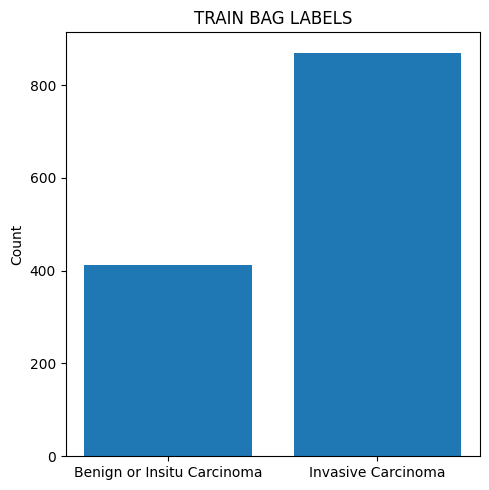

In [74]:
import matplotlib.pyplot as plt

# class distribution of train, validation, and test datasets 

def plot_bag_labels(ax, title, labels): 
    
    # Count occurrences of each class
    class_counts = [labels.count(i) for i in range(2)]
    
    # Plot the distribution
    ax.bar(['Benign or Insitu Carcinoma', 'Invasive Carcinoma'], class_counts)
    ax.set_title(title)
    ax.set_ylabel('Count')

# Plotting
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

plot_bag_labels(axs, 'TRAIN BAG LABELS', bag_labels)

plt.tight_layout()
plt.show()

**CUSTOM DATASETS** 

In [75]:
# Custom dataset to load feature vectors & binary class labels 

class CustomDataset(Dataset):
    def __init__(self, bags, labels):
        self.bags = bags
        self.labels = labels

    def __len__(self):
        return len(self.bags)

    def __getitem__(self, idx):
        
        x = self.bags[idx]
        n=300
        if len(x) > n:
            feat_map = x[:n]
        else:
            feat_map = []
            feat_map.extend([np.array([0.0] * num_features_n)] * int((num_features_n - len(x)) / 2)) # black padding above
            feat_map.extend(x) # feature map of patches in between
            feat_map.extend([np.array([0.0] * num_features_n)] * int(((num_features_n - len(x)) / 2) + 1)) # black padding below
            feat_map = feat_map[:num_features_n]
        
        x = np.array(feat_map) 
        
        x = torch.tensor(x).float()
        x = nn.functional.normalize(x, dim=0, p=2)  # p=2 for L2 norm, dim=0 for cols
        bag = x
        label = self.labels[idx]
        label = torch.tensor(label)
        
        return torch.stack([bag]), label

**DATA LOADERS** 

In [76]:
batch_size = 16  

In [77]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

**FINAL MODEL** 

In [78]:
from torch.nn import functional as F
import torchvision.models as models

class Pipeline(nn.Module):
    def __init__(self,num_classes):
        #define necessary layers
        super().__init__()
        self.num_classes = num_classes
          
        self.base = models.efficientnet_b3(weights=True)
        # Unfreeze model weights
        for param in self.base.parameters():
            param.requires_grad = True
        
        self.flatten = nn.Flatten()
        
        self.head = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        ) 
    
    def attention(self, query, key, value, mask=None, dropout=None):
        "Compute 'Scaled Dot Product Attention'"
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = scores.softmax(dim=-1)
        if dropout is not None:
            p_attn = dropout(p_attn)
        return torch.matmul(p_attn, value), p_attn
    
    def forward(self,X):
        attended_values, attention_scores = self.attention(X, X, X)
        X = self.base(attended_values)
        X = self.flatten(X)
        X = self.head(X)
        return X, F.sigmoid(X)

pos_weight = torch.tensor([0.6])
pos_weight = pos_weight.to(device)

#model = nn.DataParallel(model)

In [79]:
!export CUDA_LAUNCH_BLOCKING=1

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


**TRAINING** 

In [80]:
from sklearn.metrics import roc_curve, auc, classification_report
import math  

# Training loop
num_epochs = 20  # Adjust as needed

In [81]:
len(bag_labels)

1283

In [82]:
from collections import defaultdict

In [83]:


# Set number of folds and random seed
num_folds = 5
batch_size = 16
np.random.seed(42)  # Ensures reproducibility for shuffling

# Shuffle and split WSIs into groups with exactly 2 WSIs per fold
unique_wsis = list(set(wsis_for_bags))
np.random.shuffle(unique_wsis)  # Shuffle to randomize groupings

# Divide unique WSIs into folds, each fold containing 2 WSIs
wsi_groups = [unique_wsis[i:i + 2] for i in range(0, len(unique_wsis), 2)]

metrics = {
    fold + 1: {
        'train_loss': [], 'train_accuracy': [], 'train_roc_auc': [],
        'valid_loss': [], 'valid_accuracy': [], 'valid_roc_auc': [],
        'wsi_nos': [], 'ann_nos': [], 'y_pred': [], 'y_true': []
    } for fold in range(num_folds)
}

# Run custom cross-validation
for fold in range(num_folds):
    test_wsis = wsi_groups[fold]  # Select two WSIs for this fold's test set
    train_wsis = [wsi for group in wsi_groups if group != test_wsis for wsi in group]
    
    # Get indices for training and testing based on selected WSIs
    train_idx = [i for i, wsi in enumerate(wsis_for_bags) if wsi in train_wsis]
    test_idx = [i for i, wsi in enumerate(wsis_for_bags) if wsi in test_wsis]
    
    # Splitting bags and labels for each fold without converting to numpy array
    train_bags = [bags[i] for i in train_idx]
    test_bags = [bags[i] for i in test_idx]
    train_labels = [bag_labels[i] for i in train_idx]
    test_labels = [bag_labels[i] for i in test_idx]
    
    metrics[fold + 1]['wsi_nos'] = [wsis_for_bags[i] for i in test_idx]
    metrics[fold + 1]['ann_nos'] = [anns_for_bags[i] for i in test_idx]

    # Creating datasets and loaders for each fold
    train_dataset = CustomDataset(train_bags, train_labels)
    val_dataset = CustomDataset(test_bags, test_labels)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    valid_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Output the fold details
    print(f"\nFold {fold + 1}")
    print(f"Train WSI IDs: {set(np.array(wsis_for_bags)[train_idx])}")
    print(f"Test WSI IDs: {set(np.array(wsis_for_bags)[test_idx])}")
    print(f"Train size: {len(train_loader.dataset)}, Test size: {len(valid_loader.dataset)}")

    # Initialize empty lists to store loss and accuracy for training and validation
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    roc_values_train = []
    roc_values_val = []
    # modifying first layer for one color channel 
    loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
    model = Pipeline(1)
    #b3
    model.base.features[0][0] = nn.Conv2d(1, 40, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    #b0
    #model.base.features[0][0] = nn.Conv2d(1, 32,kernel_size= (3,3), stride = 2, padding= 1, bias=False)
    # Check if GPU is available
    if torch.cuda.is_available():
        model = model.to(device)
        print('available')

    #criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(params=model.parameters(), lr=0.000025)
    for epoch in range(num_epochs):
        model.train()
        y_true_train = []
        y_scores_train = []
        train_loss = 0
        correct = 0
        total = 0
        for images, labels in tqdm(train_loader):
            # Move data to GPU if available
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs_without_sigmoid, outputs_with_sigmoid = model(images)
            loss = loss_fn(outputs_without_sigmoid.squeeze(-1), labels.float())
            loss.backward()
            optimizer.step()
            train_loss += loss.item()  # L+=l.item()
            predicted = (outputs_with_sigmoid >= 0.5).long().squeeze(-1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_true_train.extend(labels.cpu().detach().numpy())
            y_scores_train.extend(outputs_with_sigmoid.cpu().detach().numpy())

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct / total)

        # roc auc logic
        fpr_train, tpr_train, _ = roc_curve(y_true_train, y_scores_train)
        roc_auc_train = auc(fpr_train, tpr_train)
        roc_values_train.append(roc_auc_train)

        # Plot ROC curve for the training set

        # Validate your model after each epoch if needed
        model.eval()
        valid_loss = 0
        correct = 0
        total = 0
        y_true_val = []
        y_scores_val = []
        with torch.no_grad():
            for images, labels in tqdm(valid_loader):
                # Move data to GPU if available
                images = images.to(device)
                labels = labels.to(device)
                outputs_without_sigmoid, outputs_with_sigmoid = model(images)
                loss = loss_fn(outputs_without_sigmoid.squeeze(-1), labels.float())
                valid_loss += loss.item()  # L+=l.item()
                predicted = (outputs_with_sigmoid >= 0.5).long().squeeze(-1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                y_true_val.extend(labels.cpu().detach().numpy())
                y_scores_val.extend(outputs_with_sigmoid.cpu().detach().numpy())

        valid_losses.append(valid_loss / len(valid_loader))
        valid_accuracies.append(100 * correct / total)
        # roc auc logic
        fpr_val, tpr_val, _ = roc_curve(y_true_val, y_scores_val)
        roc_auc_val = auc(fpr_val, tpr_val)
        roc_values_val.append(roc_auc_val)

        # Classification report
        print(f'Epoch {epoch + 1}, Train Accuracy: {train_accuracies[-1]:.2f}%, Train Loss: {train_losses[-1]:.2f}%, Train ROC-AUC: {roc_auc_train:.2f}%, Val Accuracy: {valid_accuracies[-1]:.2f}%, Val Loss: {valid_losses[-1]:.2f}%, Val ROC-AUC: {roc_auc_val:.2f}%')

        y_true_val = np.array(y_true_val)
        y_pred_val = (np.array(y_scores_val) >= 0.5).astype(int)
        print("Validation Classification Report:")
        print(classification_report(y_true_val, y_pred_val,zero_division=1))
        
         # Append metrics for current epoch and fold
        metrics[fold + 1]['train_loss'].append(train_losses[-1])
        metrics[fold + 1]['train_accuracy'].append(train_accuracies[-1])
        metrics[fold + 1]['train_roc_auc'].append(roc_values_train[-1])
        metrics[fold + 1]['valid_loss'].append(valid_losses[-1])
        metrics[fold + 1]['valid_accuracy'].append(valid_accuracies[-1])
        metrics[fold + 1]['valid_roc_auc'].append(roc_values_val[-1])
    metrics[fold + 1]['y_pred']=y_pred_val
    metrics[fold + 1]['y_true']=y_true_val


Fold 1
Train WSI IDs: {'A02', 'A08', 'A10', 'A05', 'A03', 'A09', 'A06', 'A07'}
Test WSI IDs: {'A01', 'A04'}
Train size: 894, Test size: 389


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 180MB/s]


available


100%|██████████| 25/25 [00:01<00:00, 18.22it/s]


Epoch 1, Train Accuracy: 60.96%, Train Loss: 0.51%, Train ROC-AUC: 0.54%, Val Accuracy: 71.21%, Val Loss: 3.71%, Val ROC-AUC: 0.51%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.14      0.01      0.02       107
           1       0.72      0.98      0.83       282

    accuracy                           0.71       389
   macro avg       0.43      0.49      0.42       389
weighted avg       0.56      0.71      0.61       389



100%|██████████| 25/25 [00:01<00:00, 18.96it/s]


Epoch 2, Train Accuracy: 74.27%, Train Loss: 0.49%, Train ROC-AUC: 0.74%, Val Accuracy: 72.75%, Val Loss: 0.47%, Val ROC-AUC: 0.76%
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.01      0.02       107
           1       0.73      1.00      0.84       282

    accuracy                           0.73       389
   macro avg       0.86      0.50      0.43       389
weighted avg       0.80      0.73      0.62       389



100%|██████████| 25/25 [00:01<00:00, 18.54it/s]


Epoch 3, Train Accuracy: 79.42%, Train Loss: 0.43%, Train ROC-AUC: 0.82%, Val Accuracy: 78.92%, Val Loss: 0.38%, Val ROC-AUC: 0.85%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.52      0.58       107
           1       0.83      0.89      0.86       282

    accuracy                           0.79       389
   macro avg       0.74      0.71      0.72       389
weighted avg       0.78      0.79      0.78       389



100%|██████████| 25/25 [00:01<00:00, 18.66it/s]


Epoch 4, Train Accuracy: 83.45%, Train Loss: 0.34%, Train ROC-AUC: 0.88%, Val Accuracy: 79.69%, Val Loss: 0.36%, Val ROC-AUC: 0.86%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.64      0.63       107
           1       0.86      0.86      0.86       282

    accuracy                           0.80       389
   macro avg       0.75      0.75      0.75       389
weighted avg       0.80      0.80      0.80       389



100%|██████████| 25/25 [00:01<00:00, 18.74it/s]


Epoch 5, Train Accuracy: 84.45%, Train Loss: 0.28%, Train ROC-AUC: 0.91%, Val Accuracy: 80.21%, Val Loss: 0.37%, Val ROC-AUC: 0.86%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.65       107
           1       0.87      0.85      0.86       282

    accuracy                           0.80       389
   macro avg       0.75      0.76      0.76       389
weighted avg       0.81      0.80      0.80       389



100%|██████████| 25/25 [00:01<00:00, 18.65it/s]


Epoch 6, Train Accuracy: 88.81%, Train Loss: 0.22%, Train ROC-AUC: 0.95%, Val Accuracy: 80.46%, Val Loss: 0.36%, Val ROC-AUC: 0.88%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.66      0.65       107
           1       0.87      0.86      0.86       282

    accuracy                           0.80       389
   macro avg       0.76      0.76      0.76       389
weighted avg       0.81      0.80      0.81       389



100%|██████████| 25/25 [00:01<00:00, 18.84it/s]


Epoch 7, Train Accuracy: 89.82%, Train Loss: 0.19%, Train ROC-AUC: 0.96%, Val Accuracy: 80.98%, Val Loss: 0.37%, Val ROC-AUC: 0.88%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.69      0.67       107
           1       0.88      0.85      0.87       282

    accuracy                           0.81       389
   macro avg       0.76      0.77      0.77       389
weighted avg       0.81      0.81      0.81       389



100%|██████████| 25/25 [00:01<00:00, 18.72it/s]


Epoch 8, Train Accuracy: 91.28%, Train Loss: 0.18%, Train ROC-AUC: 0.96%, Val Accuracy: 81.49%, Val Loss: 0.39%, Val ROC-AUC: 0.88%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.64      0.65       107
           1       0.86      0.88      0.87       282

    accuracy                           0.81       389
   macro avg       0.77      0.76      0.76       389
weighted avg       0.81      0.81      0.81       389



100%|██████████| 25/25 [00:01<00:00, 18.49it/s]


Epoch 9, Train Accuracy: 91.28%, Train Loss: 0.16%, Train ROC-AUC: 0.97%, Val Accuracy: 82.26%, Val Loss: 0.43%, Val ROC-AUC: 0.87%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.66      0.67       107
           1       0.87      0.88      0.88       282

    accuracy                           0.82       389
   macro avg       0.78      0.77      0.78       389
weighted avg       0.82      0.82      0.82       389



100%|██████████| 25/25 [00:01<00:00, 18.70it/s]


Epoch 10, Train Accuracy: 91.39%, Train Loss: 0.16%, Train ROC-AUC: 0.97%, Val Accuracy: 83.29%, Val Loss: 0.40%, Val ROC-AUC: 0.88%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.69      0.69       107
           1       0.88      0.89      0.88       282

    accuracy                           0.83       389
   macro avg       0.79      0.79      0.79       389
weighted avg       0.83      0.83      0.83       389



100%|██████████| 25/25 [00:01<00:00, 18.70it/s]


Epoch 11, Train Accuracy: 92.84%, Train Loss: 0.13%, Train ROC-AUC: 0.98%, Val Accuracy: 83.29%, Val Loss: 0.44%, Val ROC-AUC: 0.87%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.70      0.70       107
           1       0.89      0.88      0.88       282

    accuracy                           0.83       389
   macro avg       0.79      0.79      0.79       389
weighted avg       0.83      0.83      0.83       389



100%|██████████| 25/25 [00:01<00:00, 18.72it/s]


Epoch 12, Train Accuracy: 93.51%, Train Loss: 0.12%, Train ROC-AUC: 0.98%, Val Accuracy: 79.69%, Val Loss: 0.45%, Val ROC-AUC: 0.87%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.73      0.66       107
           1       0.89      0.82      0.85       282

    accuracy                           0.80       389
   macro avg       0.75      0.78      0.76       389
weighted avg       0.81      0.80      0.80       389



100%|██████████| 25/25 [00:01<00:00, 18.95it/s]


Epoch 13, Train Accuracy: 94.63%, Train Loss: 0.11%, Train ROC-AUC: 0.99%, Val Accuracy: 81.75%, Val Loss: 0.42%, Val ROC-AUC: 0.89%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.66      0.67       107
           1       0.87      0.88      0.87       282

    accuracy                           0.82       389
   macro avg       0.77      0.77      0.77       389
weighted avg       0.82      0.82      0.82       389



100%|██████████| 25/25 [00:01<00:00, 19.04it/s]


Epoch 14, Train Accuracy: 94.97%, Train Loss: 0.11%, Train ROC-AUC: 0.99%, Val Accuracy: 83.03%, Val Loss: 0.49%, Val ROC-AUC: 0.86%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.74      0.71       107
           1       0.90      0.87      0.88       282

    accuracy                           0.83       389
   macro avg       0.79      0.80      0.79       389
weighted avg       0.84      0.83      0.83       389



100%|██████████| 25/25 [00:01<00:00, 19.06it/s]


Epoch 15, Train Accuracy: 95.30%, Train Loss: 0.09%, Train ROC-AUC: 0.99%, Val Accuracy: 83.03%, Val Loss: 0.49%, Val ROC-AUC: 0.87%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.79      0.72       107
           1       0.92      0.84      0.88       282

    accuracy                           0.83       389
   macro avg       0.79      0.82      0.80       389
weighted avg       0.84      0.83      0.83       389



100%|██████████| 25/25 [00:01<00:00, 19.01it/s]


Epoch 16, Train Accuracy: 95.41%, Train Loss: 0.08%, Train ROC-AUC: 0.99%, Val Accuracy: 81.49%, Val Loss: 0.53%, Val ROC-AUC: 0.85%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.79      0.70       107
           1       0.91      0.83      0.87       282

    accuracy                           0.81       389
   macro avg       0.77      0.81      0.78       389
weighted avg       0.83      0.81      0.82       389



100%|██████████| 25/25 [00:01<00:00, 19.08it/s]


Epoch 17, Train Accuracy: 95.64%, Train Loss: 0.08%, Train ROC-AUC: 0.99%, Val Accuracy: 82.52%, Val Loss: 0.53%, Val ROC-AUC: 0.86%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.79      0.71       107
           1       0.91      0.84      0.87       282

    accuracy                           0.83       389
   macro avg       0.78      0.81      0.79       389
weighted avg       0.84      0.83      0.83       389



100%|██████████| 25/25 [00:01<00:00, 18.26it/s]


Epoch 18, Train Accuracy: 96.64%, Train Loss: 0.07%, Train ROC-AUC: 1.00%, Val Accuracy: 82.01%, Val Loss: 0.55%, Val ROC-AUC: 0.86%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.79      0.71       107
           1       0.91      0.83      0.87       282

    accuracy                           0.82       389
   macro avg       0.78      0.81      0.79       389
weighted avg       0.84      0.82      0.83       389



100%|██████████| 25/25 [00:01<00:00, 19.08it/s]


Epoch 19, Train Accuracy: 96.31%, Train Loss: 0.08%, Train ROC-AUC: 0.99%, Val Accuracy: 80.98%, Val Loss: 0.54%, Val ROC-AUC: 0.88%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.77      0.69       107
           1       0.90      0.83      0.86       282

    accuracy                           0.81       389
   macro avg       0.76      0.80      0.78       389
weighted avg       0.83      0.81      0.82       389



100%|██████████| 25/25 [00:01<00:00, 18.99it/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 20, Train Accuracy: 96.76%, Train Loss: 0.07%, Train ROC-AUC: 1.00%, Val Accuracy: 82.26%, Val Loss: 0.55%, Val ROC-AUC: 0.88%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.74      0.70       107
           1       0.90      0.85      0.87       282

    accuracy                           0.82       389
   macro avg       0.78      0.80      0.79       389
weighted avg       0.83      0.82      0.83       389


Fold 2
Train WSI IDs: {'A08', 'A04', 'A10', 'A05', 'A09', 'A06', 'A01', 'A07'}
Test WSI IDs: {'A02', 'A03'}
Train size: 1078, Test size: 205
available


100%|██████████| 13/13 [00:00<00:00, 18.31it/s]


Epoch 1, Train Accuracy: 61.78%, Train Loss: 0.49%, Train ROC-AUC: 0.59%, Val Accuracy: 61.46%, Val Loss: 12.06%, Val ROC-AUC: 0.49%
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00        79
           1       0.61      1.00      0.76       126

    accuracy                           0.61       205
   macro avg       0.81      0.50      0.38       205
weighted avg       0.76      0.61      0.47       205



100%|██████████| 13/13 [00:00<00:00, 18.72it/s]


Epoch 2, Train Accuracy: 76.07%, Train Loss: 0.43%, Train ROC-AUC: 0.79%, Val Accuracy: 63.90%, Val Loss: 0.48%, Val ROC-AUC: 0.76%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.68      0.59        79
           1       0.75      0.61      0.68       126

    accuracy                           0.64       205
   macro avg       0.64      0.65      0.63       205
weighted avg       0.67      0.64      0.64       205



100%|██████████| 13/13 [00:00<00:00, 18.78it/s]


Epoch 3, Train Accuracy: 81.54%, Train Loss: 0.35%, Train ROC-AUC: 0.87%, Val Accuracy: 79.51%, Val Loss: 0.38%, Val ROC-AUC: 0.89%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.70      0.72        79
           1       0.82      0.86      0.84       126

    accuracy                           0.80       205
   macro avg       0.79      0.78      0.78       205
weighted avg       0.79      0.80      0.79       205



100%|██████████| 13/13 [00:00<00:00, 18.89it/s]


Epoch 4, Train Accuracy: 83.40%, Train Loss: 0.31%, Train ROC-AUC: 0.89%, Val Accuracy: 79.51%, Val Loss: 0.34%, Val ROC-AUC: 0.89%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.81      0.75        79
           1       0.87      0.79      0.82       126

    accuracy                           0.80       205
   macro avg       0.79      0.80      0.79       205
weighted avg       0.80      0.80      0.80       205



100%|██████████| 13/13 [00:00<00:00, 18.71it/s]


Epoch 5, Train Accuracy: 82.93%, Train Loss: 0.27%, Train ROC-AUC: 0.91%, Val Accuracy: 81.95%, Val Loss: 0.29%, Val ROC-AUC: 0.92%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        79
           1       0.88      0.82      0.85       126

    accuracy                           0.82       205
   macro avg       0.81      0.82      0.81       205
weighted avg       0.83      0.82      0.82       205



100%|██████████| 13/13 [00:00<00:00, 18.91it/s]


Epoch 6, Train Accuracy: 86.83%, Train Loss: 0.24%, Train ROC-AUC: 0.94%, Val Accuracy: 82.44%, Val Loss: 0.27%, Val ROC-AUC: 0.93%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.84      0.79        79
           1       0.89      0.82      0.85       126

    accuracy                           0.82       205
   macro avg       0.81      0.83      0.82       205
weighted avg       0.83      0.82      0.83       205



100%|██████████| 13/13 [00:00<00:00, 18.88it/s]


Epoch 7, Train Accuracy: 84.88%, Train Loss: 0.23%, Train ROC-AUC: 0.93%, Val Accuracy: 81.95%, Val Loss: 0.29%, Val ROC-AUC: 0.93%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        79
           1       0.88      0.82      0.85       126

    accuracy                           0.82       205
   macro avg       0.81      0.82      0.81       205
weighted avg       0.83      0.82      0.82       205



100%|██████████| 13/13 [00:00<00:00, 18.98it/s]


Epoch 8, Train Accuracy: 88.31%, Train Loss: 0.20%, Train ROC-AUC: 0.95%, Val Accuracy: 83.41%, Val Loss: 0.28%, Val ROC-AUC: 0.93%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.81      0.79        79
           1       0.88      0.85      0.86       126

    accuracy                           0.83       205
   macro avg       0.82      0.83      0.83       205
weighted avg       0.84      0.83      0.83       205



100%|██████████| 13/13 [00:00<00:00, 18.68it/s]


Epoch 9, Train Accuracy: 89.80%, Train Loss: 0.17%, Train ROC-AUC: 0.97%, Val Accuracy: 80.49%, Val Loss: 0.41%, Val ROC-AUC: 0.91%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.77      0.75        79
           1       0.85      0.83      0.84       126

    accuracy                           0.80       205
   macro avg       0.79      0.80      0.80       205
weighted avg       0.81      0.80      0.81       205



100%|██████████| 13/13 [00:00<00:00, 18.84it/s]


Epoch 10, Train Accuracy: 89.80%, Train Loss: 0.18%, Train ROC-AUC: 0.96%, Val Accuracy: 81.46%, Val Loss: 0.38%, Val ROC-AUC: 0.92%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.76      0.76        79
           1       0.85      0.85      0.85       126

    accuracy                           0.81       205
   macro avg       0.80      0.80      0.80       205
weighted avg       0.81      0.81      0.81       205



100%|██████████| 13/13 [00:00<00:00, 18.59it/s]


Epoch 11, Train Accuracy: 91.65%, Train Loss: 0.14%, Train ROC-AUC: 0.98%, Val Accuracy: 82.93%, Val Loss: 0.33%, Val ROC-AUC: 0.93%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.81      0.79        79
           1       0.88      0.84      0.86       126

    accuracy                           0.83       205
   macro avg       0.82      0.83      0.82       205
weighted avg       0.83      0.83      0.83       205



100%|██████████| 13/13 [00:00<00:00, 18.91it/s]


Epoch 12, Train Accuracy: 91.74%, Train Loss: 0.14%, Train ROC-AUC: 0.98%, Val Accuracy: 81.46%, Val Loss: 0.39%, Val ROC-AUC: 0.92%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.77        79
           1       0.86      0.83      0.85       126

    accuracy                           0.81       205
   macro avg       0.80      0.81      0.81       205
weighted avg       0.82      0.81      0.82       205



100%|██████████| 13/13 [00:00<00:00, 19.04it/s]


Epoch 13, Train Accuracy: 92.95%, Train Loss: 0.15%, Train ROC-AUC: 0.97%, Val Accuracy: 83.41%, Val Loss: 0.33%, Val ROC-AUC: 0.93%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.84      0.80        79
           1       0.89      0.83      0.86       126

    accuracy                           0.83       205
   macro avg       0.82      0.83      0.83       205
weighted avg       0.84      0.83      0.84       205



100%|██████████| 13/13 [00:00<00:00, 18.78it/s]


Epoch 14, Train Accuracy: 91.00%, Train Loss: 0.15%, Train ROC-AUC: 0.97%, Val Accuracy: 81.46%, Val Loss: 0.34%, Val ROC-AUC: 0.93%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.78      0.77        79
           1       0.86      0.83      0.85       126

    accuracy                           0.81       205
   macro avg       0.80      0.81      0.81       205
weighted avg       0.82      0.81      0.82       205



100%|██████████| 13/13 [00:00<00:00, 17.56it/s]


Epoch 15, Train Accuracy: 93.60%, Train Loss: 0.12%, Train ROC-AUC: 0.98%, Val Accuracy: 80.00%, Val Loss: 0.38%, Val ROC-AUC: 0.92%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.78      0.75        79
           1       0.86      0.81      0.83       126

    accuracy                           0.80       205
   macro avg       0.79      0.80      0.79       205
weighted avg       0.80      0.80      0.80       205



100%|██████████| 13/13 [00:00<00:00, 18.80it/s]


Epoch 16, Train Accuracy: 95.27%, Train Loss: 0.10%, Train ROC-AUC: 0.99%, Val Accuracy: 83.90%, Val Loss: 0.33%, Val ROC-AUC: 0.94%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.85      0.80        79
           1       0.90      0.83      0.86       126

    accuracy                           0.84       205
   macro avg       0.83      0.84      0.83       205
weighted avg       0.84      0.84      0.84       205



100%|██████████| 13/13 [00:00<00:00, 18.78it/s]


Epoch 17, Train Accuracy: 94.90%, Train Loss: 0.11%, Train ROC-AUC: 0.98%, Val Accuracy: 81.95%, Val Loss: 0.36%, Val ROC-AUC: 0.93%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.77        79
           1       0.87      0.83      0.85       126

    accuracy                           0.82       205
   macro avg       0.81      0.82      0.81       205
weighted avg       0.82      0.82      0.82       205



100%|██████████| 13/13 [00:00<00:00, 18.63it/s]


Epoch 18, Train Accuracy: 94.53%, Train Loss: 0.10%, Train ROC-AUC: 0.99%, Val Accuracy: 82.44%, Val Loss: 0.38%, Val ROC-AUC: 0.93%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78        79
           1       0.88      0.83      0.85       126

    accuracy                           0.82       205
   macro avg       0.81      0.82      0.82       205
weighted avg       0.83      0.82      0.83       205



100%|██████████| 13/13 [00:00<00:00, 18.92it/s]


Epoch 19, Train Accuracy: 94.43%, Train Loss: 0.10%, Train ROC-AUC: 0.99%, Val Accuracy: 84.39%, Val Loss: 0.34%, Val ROC-AUC: 0.94%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.89      0.81        79
           1       0.92      0.82      0.87       126

    accuracy                           0.84       205
   macro avg       0.84      0.85      0.84       205
weighted avg       0.86      0.84      0.85       205



100%|██████████| 13/13 [00:00<00:00, 18.86it/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 20, Train Accuracy: 95.73%, Train Loss: 0.09%, Train ROC-AUC: 0.99%, Val Accuracy: 80.49%, Val Loss: 0.39%, Val ROC-AUC: 0.93%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.82      0.76        79
           1       0.88      0.79      0.83       126

    accuracy                           0.80       205
   macro avg       0.80      0.81      0.80       205
weighted avg       0.81      0.80      0.81       205


Fold 3
Train WSI IDs: {'A02', 'A04', 'A10', 'A07', 'A03', 'A09', 'A01', 'A05'}
Test WSI IDs: {'A08', 'A06'}
Train size: 1055, Test size: 228
available


100%|██████████| 15/15 [00:00<00:00, 18.77it/s]


Epoch 1, Train Accuracy: 68.53%, Train Loss: 0.47%, Train ROC-AUC: 0.64%, Val Accuracy: 55.70%, Val Loss: 123.73%, Val ROC-AUC: 0.49%
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       101
           1       0.56      1.00      0.72       127

    accuracy                           0.56       228
   macro avg       0.78      0.50      0.36       228
weighted avg       0.75      0.56      0.40       228



100%|██████████| 15/15 [00:00<00:00, 19.62it/s]


Epoch 2, Train Accuracy: 77.16%, Train Loss: 0.39%, Train ROC-AUC: 0.83%, Val Accuracy: 78.95%, Val Loss: 0.39%, Val ROC-AUC: 0.90%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.88      0.79       101
           1       0.88      0.72      0.79       127

    accuracy                           0.79       228
   macro avg       0.80      0.80      0.79       228
weighted avg       0.81      0.79      0.79       228



100%|██████████| 15/15 [00:00<00:00, 19.54it/s]


Epoch 3, Train Accuracy: 82.46%, Train Loss: 0.31%, Train ROC-AUC: 0.89%, Val Accuracy: 63.60%, Val Loss: 0.40%, Val ROC-AUC: 0.92%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.98      0.70       101
           1       0.96      0.36      0.53       127

    accuracy                           0.64       228
   macro avg       0.75      0.67      0.62       228
weighted avg       0.78      0.64      0.60       228



100%|██████████| 15/15 [00:00<00:00, 19.53it/s]


Epoch 4, Train Accuracy: 85.12%, Train Loss: 0.25%, Train ROC-AUC: 0.93%, Val Accuracy: 73.25%, Val Loss: 0.32%, Val ROC-AUC: 0.94%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.98      0.76       101
           1       0.97      0.54      0.69       127

    accuracy                           0.73       228
   macro avg       0.80      0.76      0.73       228
weighted avg       0.82      0.73      0.72       228



100%|██████████| 15/15 [00:00<00:00, 19.45it/s]


Epoch 5, Train Accuracy: 87.01%, Train Loss: 0.21%, Train ROC-AUC: 0.95%, Val Accuracy: 69.30%, Val Loss: 0.37%, Val ROC-AUC: 0.94%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.99      0.74       101
           1       0.98      0.46      0.62       127

    accuracy                           0.69       228
   macro avg       0.79      0.72      0.68       228
weighted avg       0.81      0.69      0.68       228



100%|██████████| 15/15 [00:00<00:00, 19.38it/s]


Epoch 6, Train Accuracy: 88.91%, Train Loss: 0.19%, Train ROC-AUC: 0.96%, Val Accuracy: 69.30%, Val Loss: 0.36%, Val ROC-AUC: 0.93%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.95      0.73       101
           1       0.93      0.49      0.64       127

    accuracy                           0.69       228
   macro avg       0.76      0.72      0.69       228
weighted avg       0.78      0.69      0.68       228



100%|██████████| 15/15 [00:00<00:00, 19.19it/s]


Epoch 7, Train Accuracy: 89.29%, Train Loss: 0.19%, Train ROC-AUC: 0.96%, Val Accuracy: 68.86%, Val Loss: 0.33%, Val ROC-AUC: 0.96%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.99      0.74       101
           1       0.98      0.45      0.62       127

    accuracy                           0.69       228
   macro avg       0.79      0.72      0.68       228
weighted avg       0.81      0.69      0.67       228



100%|██████████| 15/15 [00:00<00:00, 19.59it/s]


Epoch 8, Train Accuracy: 90.62%, Train Loss: 0.17%, Train ROC-AUC: 0.96%, Val Accuracy: 73.25%, Val Loss: 0.34%, Val ROC-AUC: 0.94%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.95      0.76       101
           1       0.93      0.56      0.70       127

    accuracy                           0.73       228
   macro avg       0.78      0.75      0.73       228
weighted avg       0.80      0.73      0.73       228



100%|██████████| 15/15 [00:00<00:00, 19.20it/s]


Epoch 9, Train Accuracy: 89.95%, Train Loss: 0.16%, Train ROC-AUC: 0.97%, Val Accuracy: 76.75%, Val Loss: 0.29%, Val ROC-AUC: 0.96%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.98      0.79       101
           1       0.97      0.60      0.74       127

    accuracy                           0.77       228
   macro avg       0.82      0.79      0.77       228
weighted avg       0.84      0.77      0.76       228



100%|██████████| 15/15 [00:00<00:00, 19.36it/s]


Epoch 10, Train Accuracy: 93.18%, Train Loss: 0.13%, Train ROC-AUC: 0.98%, Val Accuracy: 74.56%, Val Loss: 0.33%, Val ROC-AUC: 0.95%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.97      0.77       101
           1       0.96      0.57      0.71       127

    accuracy                           0.75       228
   macro avg       0.80      0.77      0.74       228
weighted avg       0.82      0.75      0.74       228



100%|██████████| 15/15 [00:00<00:00, 19.60it/s]


Epoch 11, Train Accuracy: 92.99%, Train Loss: 0.12%, Train ROC-AUC: 0.98%, Val Accuracy: 75.00%, Val Loss: 0.34%, Val ROC-AUC: 0.94%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.95      0.77       101
           1       0.94      0.59      0.72       127

    accuracy                           0.75       228
   macro avg       0.79      0.77      0.75       228
weighted avg       0.81      0.75      0.75       228



100%|██████████| 15/15 [00:00<00:00, 18.03it/s]


Epoch 12, Train Accuracy: 93.55%, Train Loss: 0.12%, Train ROC-AUC: 0.98%, Val Accuracy: 80.70%, Val Loss: 0.29%, Val ROC-AUC: 0.96%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.95      0.81       101
           1       0.95      0.69      0.80       127

    accuracy                           0.81       228
   macro avg       0.83      0.82      0.81       228
weighted avg       0.84      0.81      0.81       228



100%|██████████| 15/15 [00:00<00:00, 19.29it/s]


Epoch 13, Train Accuracy: 94.31%, Train Loss: 0.11%, Train ROC-AUC: 0.99%, Val Accuracy: 79.82%, Val Loss: 0.33%, Val ROC-AUC: 0.95%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.97      0.81       101
           1       0.97      0.66      0.79       127

    accuracy                           0.80       228
   macro avg       0.83      0.82      0.80       228
weighted avg       0.85      0.80      0.80       228



100%|██████████| 15/15 [00:00<00:00, 19.55it/s]


Epoch 14, Train Accuracy: 93.46%, Train Loss: 0.13%, Train ROC-AUC: 0.98%, Val Accuracy: 78.95%, Val Loss: 0.28%, Val ROC-AUC: 0.97%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.96      0.80       101
           1       0.95      0.65      0.78       127

    accuracy                           0.79       228
   macro avg       0.82      0.81      0.79       228
weighted avg       0.84      0.79      0.79       228



100%|██████████| 15/15 [00:00<00:00, 19.38it/s]


Epoch 15, Train Accuracy: 95.92%, Train Loss: 0.09%, Train ROC-AUC: 0.99%, Val Accuracy: 73.25%, Val Loss: 0.39%, Val ROC-AUC: 0.95%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.96      0.76       101
           1       0.95      0.55      0.70       127

    accuracy                           0.73       228
   macro avg       0.79      0.76      0.73       228
weighted avg       0.81      0.73      0.72       228



100%|██████████| 15/15 [00:00<00:00, 19.38it/s]


Epoch 16, Train Accuracy: 96.78%, Train Loss: 0.06%, Train ROC-AUC: 1.00%, Val Accuracy: 74.12%, Val Loss: 0.40%, Val ROC-AUC: 0.94%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.94      0.76       101
           1       0.93      0.58      0.71       127

    accuracy                           0.74       228
   macro avg       0.78      0.76      0.74       228
weighted avg       0.80      0.74      0.74       228



100%|██████████| 15/15 [00:00<00:00, 19.42it/s]


Epoch 17, Train Accuracy: 94.60%, Train Loss: 0.10%, Train ROC-AUC: 0.99%, Val Accuracy: 73.25%, Val Loss: 0.43%, Val ROC-AUC: 0.96%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.98      0.76       101
           1       0.97      0.54      0.69       127

    accuracy                           0.73       228
   macro avg       0.80      0.76      0.73       228
weighted avg       0.82      0.73      0.72       228



100%|██████████| 15/15 [00:00<00:00, 19.48it/s]


Epoch 18, Train Accuracy: 96.11%, Train Loss: 0.08%, Train ROC-AUC: 0.99%, Val Accuracy: 71.49%, Val Loss: 0.41%, Val ROC-AUC: 0.96%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.95      0.75       101
           1       0.93      0.53      0.67       127

    accuracy                           0.71       228
   macro avg       0.77      0.74      0.71       228
weighted avg       0.79      0.71      0.71       228



100%|██████████| 15/15 [00:00<00:00, 19.52it/s]


Epoch 19, Train Accuracy: 96.49%, Train Loss: 0.07%, Train ROC-AUC: 0.99%, Val Accuracy: 83.33%, Val Loss: 0.26%, Val ROC-AUC: 0.97%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.96      0.84       101
           1       0.96      0.73      0.83       127

    accuracy                           0.83       228
   macro avg       0.85      0.85      0.83       228
weighted avg       0.86      0.83      0.83       228



100%|██████████| 15/15 [00:00<00:00, 19.60it/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 20, Train Accuracy: 97.06%, Train Loss: 0.07%, Train ROC-AUC: 0.99%, Val Accuracy: 78.07%, Val Loss: 0.36%, Val ROC-AUC: 0.97%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.98      0.80       101
           1       0.98      0.62      0.76       127

    accuracy                           0.78       228
   macro avg       0.82      0.80      0.78       228
weighted avg       0.84      0.78      0.78       228


Fold 4
Train WSI IDs: {'A02', 'A04', 'A08', 'A10', 'A03', 'A09', 'A06', 'A01'}
Test WSI IDs: {'A07', 'A05'}
Train size: 980, Test size: 303
available


100%|██████████| 19/19 [00:01<00:00, 18.88it/s]


Epoch 1, Train Accuracy: 67.65%, Train Loss: 0.49%, Train ROC-AUC: 0.63%, Val Accuracy: 67.00%, Val Loss: 0.50%, Val ROC-AUC: 0.67%
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.00      0.00       100
           1       0.67      1.00      0.80       203

    accuracy                           0.67       303
   macro avg       0.83      0.50      0.40       303
weighted avg       0.78      0.67      0.54       303



100%|██████████| 19/19 [00:01<00:00, 18.94it/s]


Epoch 2, Train Accuracy: 72.24%, Train Loss: 0.45%, Train ROC-AUC: 0.78%, Val Accuracy: 74.26%, Val Loss: 0.45%, Val ROC-AUC: 0.84%
Validation Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.22      0.36       100
           1       0.72      1.00      0.84       203

    accuracy                           0.74       303
   macro avg       0.86      0.61      0.60       303
weighted avg       0.81      0.74      0.68       303



100%|██████████| 19/19 [00:01<00:00, 18.78it/s]


Epoch 3, Train Accuracy: 81.33%, Train Loss: 0.38%, Train ROC-AUC: 0.85%, Val Accuracy: 89.11%, Val Loss: 0.29%, Val ROC-AUC: 0.93%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83       100
           1       0.92      0.92      0.92       203

    accuracy                           0.89       303
   macro avg       0.88      0.88      0.88       303
weighted avg       0.89      0.89      0.89       303



100%|██████████| 19/19 [00:01<00:00, 18.89it/s]


Epoch 4, Train Accuracy: 83.47%, Train Loss: 0.31%, Train ROC-AUC: 0.90%, Val Accuracy: 88.45%, Val Loss: 0.23%, Val ROC-AUC: 0.95%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.85      0.83       100
           1       0.92      0.90      0.91       203

    accuracy                           0.88       303
   macro avg       0.87      0.88      0.87       303
weighted avg       0.89      0.88      0.89       303



100%|██████████| 19/19 [00:01<00:00, 18.62it/s]


Epoch 5, Train Accuracy: 84.18%, Train Loss: 0.28%, Train ROC-AUC: 0.91%, Val Accuracy: 88.45%, Val Loss: 0.20%, Val ROC-AUC: 0.95%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.86      0.83       100
           1       0.93      0.90      0.91       203

    accuracy                           0.88       303
   macro avg       0.87      0.88      0.87       303
weighted avg       0.89      0.88      0.89       303



100%|██████████| 19/19 [00:01<00:00, 18.83it/s]


Epoch 6, Train Accuracy: 86.22%, Train Loss: 0.23%, Train ROC-AUC: 0.94%, Val Accuracy: 90.76%, Val Loss: 0.20%, Val ROC-AUC: 0.95%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.83      0.86       100
           1       0.92      0.95      0.93       203

    accuracy                           0.91       303
   macro avg       0.90      0.89      0.89       303
weighted avg       0.91      0.91      0.91       303



100%|██████████| 19/19 [00:01<00:00, 18.74it/s]


Epoch 7, Train Accuracy: 86.94%, Train Loss: 0.24%, Train ROC-AUC: 0.94%, Val Accuracy: 90.76%, Val Loss: 0.21%, Val ROC-AUC: 0.95%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.80      0.85       100
           1       0.91      0.96      0.93       203

    accuracy                           0.91       303
   macro avg       0.91      0.88      0.89       303
weighted avg       0.91      0.91      0.91       303



100%|██████████| 19/19 [00:01<00:00, 18.50it/s]


Epoch 8, Train Accuracy: 88.57%, Train Loss: 0.20%, Train ROC-AUC: 0.95%, Val Accuracy: 90.10%, Val Loss: 0.21%, Val ROC-AUC: 0.95%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.81      0.84       100
           1       0.91      0.95      0.93       203

    accuracy                           0.90       303
   macro avg       0.90      0.88      0.89       303
weighted avg       0.90      0.90      0.90       303



100%|██████████| 19/19 [00:01<00:00, 18.76it/s]


Epoch 9, Train Accuracy: 87.86%, Train Loss: 0.21%, Train ROC-AUC: 0.95%, Val Accuracy: 89.77%, Val Loss: 0.21%, Val ROC-AUC: 0.95%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.79      0.84       100
           1       0.90      0.95      0.93       203

    accuracy                           0.90       303
   macro avg       0.89      0.87      0.88       303
weighted avg       0.90      0.90      0.90       303



100%|██████████| 19/19 [00:01<00:00, 18.56it/s]


Epoch 10, Train Accuracy: 91.02%, Train Loss: 0.19%, Train ROC-AUC: 0.96%, Val Accuracy: 85.81%, Val Loss: 0.25%, Val ROC-AUC: 0.93%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.74      0.77       100
           1       0.88      0.92      0.90       203

    accuracy                           0.86       303
   macro avg       0.85      0.83      0.84       303
weighted avg       0.86      0.86      0.86       303



100%|██████████| 19/19 [00:01<00:00, 18.86it/s]


Epoch 11, Train Accuracy: 92.14%, Train Loss: 0.16%, Train ROC-AUC: 0.97%, Val Accuracy: 89.44%, Val Loss: 0.24%, Val ROC-AUC: 0.96%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.76      0.83       100
           1       0.89      0.96      0.92       203

    accuracy                           0.89       303
   macro avg       0.90      0.86      0.88       303
weighted avg       0.90      0.89      0.89       303



100%|██████████| 19/19 [00:01<00:00, 18.99it/s]


Epoch 12, Train Accuracy: 91.73%, Train Loss: 0.16%, Train ROC-AUC: 0.97%, Val Accuracy: 87.46%, Val Loss: 0.31%, Val ROC-AUC: 0.95%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.72      0.79       100
           1       0.87      0.95      0.91       203

    accuracy                           0.87       303
   macro avg       0.88      0.84      0.85       303
weighted avg       0.87      0.87      0.87       303



100%|██████████| 19/19 [00:01<00:00, 18.90it/s]


Epoch 13, Train Accuracy: 92.14%, Train Loss: 0.15%, Train ROC-AUC: 0.97%, Val Accuracy: 88.45%, Val Loss: 0.27%, Val ROC-AUC: 0.94%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.75      0.81       100
           1       0.89      0.95      0.92       203

    accuracy                           0.88       303
   macro avg       0.88      0.85      0.86       303
weighted avg       0.88      0.88      0.88       303



100%|██████████| 19/19 [00:01<00:00, 18.82it/s]


Epoch 14, Train Accuracy: 93.27%, Train Loss: 0.14%, Train ROC-AUC: 0.98%, Val Accuracy: 87.13%, Val Loss: 0.29%, Val ROC-AUC: 0.93%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.76      0.80       100
           1       0.89      0.93      0.91       203

    accuracy                           0.87       303
   macro avg       0.86      0.84      0.85       303
weighted avg       0.87      0.87      0.87       303



100%|██████████| 19/19 [00:01<00:00, 18.77it/s]


Epoch 15, Train Accuracy: 92.86%, Train Loss: 0.14%, Train ROC-AUC: 0.98%, Val Accuracy: 87.79%, Val Loss: 0.28%, Val ROC-AUC: 0.94%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.76      0.80       100
           1       0.89      0.94      0.91       203

    accuracy                           0.88       303
   macro avg       0.87      0.85      0.86       303
weighted avg       0.88      0.88      0.88       303



100%|██████████| 19/19 [00:01<00:00, 18.95it/s]


Epoch 16, Train Accuracy: 92.35%, Train Loss: 0.14%, Train ROC-AUC: 0.98%, Val Accuracy: 86.14%, Val Loss: 0.31%, Val ROC-AUC: 0.94%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.67      0.76       100
           1       0.85      0.96      0.90       203

    accuracy                           0.86       303
   macro avg       0.87      0.81      0.83       303
weighted avg       0.86      0.86      0.86       303



100%|██████████| 19/19 [00:01<00:00, 18.93it/s]


Epoch 17, Train Accuracy: 92.86%, Train Loss: 0.13%, Train ROC-AUC: 0.98%, Val Accuracy: 86.47%, Val Loss: 0.29%, Val ROC-AUC: 0.94%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.74      0.78       100
           1       0.88      0.93      0.90       203

    accuracy                           0.86       303
   macro avg       0.85      0.83      0.84       303
weighted avg       0.86      0.86      0.86       303



100%|██████████| 19/19 [00:01<00:00, 18.89it/s]


Epoch 18, Train Accuracy: 94.80%, Train Loss: 0.11%, Train ROC-AUC: 0.99%, Val Accuracy: 87.46%, Val Loss: 0.27%, Val ROC-AUC: 0.94%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.81      0.81       100
           1       0.91      0.91      0.91       203

    accuracy                           0.87       303
   macro avg       0.86      0.86      0.86       303
weighted avg       0.87      0.87      0.87       303



100%|██████████| 19/19 [00:01<00:00, 18.94it/s]


Epoch 19, Train Accuracy: 94.29%, Train Loss: 0.10%, Train ROC-AUC: 0.99%, Val Accuracy: 87.46%, Val Loss: 0.30%, Val ROC-AUC: 0.94%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.79      0.81       100
           1       0.90      0.92      0.91       203

    accuracy                           0.87       303
   macro avg       0.86      0.85      0.86       303
weighted avg       0.87      0.87      0.87       303



100%|██████████| 19/19 [00:01<00:00, 18.76it/s]
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 20, Train Accuracy: 95.51%, Train Loss: 0.09%, Train ROC-AUC: 0.99%, Val Accuracy: 84.82%, Val Loss: 0.31%, Val ROC-AUC: 0.93%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.80      0.78       100
           1       0.90      0.87      0.89       203

    accuracy                           0.85       303
   macro avg       0.83      0.84      0.83       303
weighted avg       0.85      0.85      0.85       303


Fold 5
Train WSI IDs: {'A02', 'A04', 'A08', 'A07', 'A03', 'A06', 'A01', 'A05'}
Test WSI IDs: {'A10', 'A09'}
Train size: 1125, Test size: 158
available


100%|██████████| 10/10 [00:00<00:00, 19.04it/s]


Epoch 1, Train Accuracy: 66.40%, Train Loss: 0.50%, Train ROC-AUC: 0.69%, Val Accuracy: 81.01%, Val Loss: 1.42%, Val ROC-AUC: 0.51%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        26
           1       0.83      0.97      0.90       132

    accuracy                           0.81       158
   macro avg       0.42      0.48      0.45       158
weighted avg       0.69      0.81      0.75       158



100%|██████████| 10/10 [00:00<00:00, 19.09it/s]


Epoch 2, Train Accuracy: 74.67%, Train Loss: 0.43%, Train ROC-AUC: 0.81%, Val Accuracy: 55.70%, Val Loss: 0.43%, Val ROC-AUC: 0.80%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.24      0.81      0.38        26
           1       0.93      0.51      0.66       132

    accuracy                           0.56       158
   macro avg       0.59      0.66      0.52       158
weighted avg       0.82      0.56      0.61       158



100%|██████████| 10/10 [00:00<00:00, 19.07it/s]


Epoch 3, Train Accuracy: 80.18%, Train Loss: 0.33%, Train ROC-AUC: 0.88%, Val Accuracy: 82.28%, Val Loss: 0.26%, Val ROC-AUC: 0.90%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.81      0.60        26
           1       0.96      0.83      0.89       132

    accuracy                           0.82       158
   macro avg       0.72      0.82      0.74       158
weighted avg       0.88      0.82      0.84       158



100%|██████████| 10/10 [00:00<00:00, 19.01it/s]


Epoch 4, Train Accuracy: 83.29%, Train Loss: 0.28%, Train ROC-AUC: 0.91%, Val Accuracy: 78.48%, Val Loss: 0.27%, Val ROC-AUC: 0.90%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.73      0.53        26
           1       0.94      0.80      0.86       132

    accuracy                           0.78       158
   macro avg       0.68      0.76      0.69       158
weighted avg       0.85      0.78      0.81       158



100%|██████████| 10/10 [00:00<00:00, 18.98it/s]


Epoch 5, Train Accuracy: 84.62%, Train Loss: 0.25%, Train ROC-AUC: 0.93%, Val Accuracy: 77.85%, Val Loss: 0.30%, Val ROC-AUC: 0.90%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.77      0.53        26
           1       0.94      0.78      0.85       132

    accuracy                           0.78       158
   macro avg       0.68      0.77      0.69       158
weighted avg       0.86      0.78      0.80       158



100%|██████████| 10/10 [00:00<00:00, 19.05it/s]


Epoch 6, Train Accuracy: 89.60%, Train Loss: 0.20%, Train ROC-AUC: 0.96%, Val Accuracy: 80.38%, Val Loss: 0.29%, Val ROC-AUC: 0.90%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.77      0.56        26
           1       0.95      0.81      0.87       132

    accuracy                           0.80       158
   macro avg       0.70      0.79      0.72       158
weighted avg       0.86      0.80      0.82       158



100%|██████████| 10/10 [00:00<00:00, 19.09it/s]


Epoch 7, Train Accuracy: 89.87%, Train Loss: 0.18%, Train ROC-AUC: 0.96%, Val Accuracy: 81.01%, Val Loss: 0.31%, Val ROC-AUC: 0.90%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.81      0.58        26
           1       0.96      0.81      0.88       132

    accuracy                           0.81       158
   macro avg       0.71      0.81      0.73       158
weighted avg       0.87      0.81      0.83       158



100%|██████████| 10/10 [00:00<00:00, 19.16it/s]


Epoch 8, Train Accuracy: 91.64%, Train Loss: 0.15%, Train ROC-AUC: 0.97%, Val Accuracy: 81.01%, Val Loss: 0.30%, Val ROC-AUC: 0.91%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.85      0.59        26
           1       0.96      0.80      0.88       132

    accuracy                           0.81       158
   macro avg       0.71      0.82      0.74       158
weighted avg       0.88      0.81      0.83       158



100%|██████████| 10/10 [00:00<00:00, 19.14it/s]


Epoch 9, Train Accuracy: 92.27%, Train Loss: 0.15%, Train ROC-AUC: 0.98%, Val Accuracy: 75.95%, Val Loss: 0.38%, Val ROC-AUC: 0.90%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.39      0.85      0.54        26
           1       0.96      0.74      0.84       132

    accuracy                           0.76       158
   macro avg       0.68      0.79      0.69       158
weighted avg       0.87      0.76      0.79       158



100%|██████████| 10/10 [00:00<00:00, 19.03it/s]


Epoch 10, Train Accuracy: 91.56%, Train Loss: 0.16%, Train ROC-AUC: 0.97%, Val Accuracy: 79.11%, Val Loss: 0.36%, Val ROC-AUC: 0.88%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.73      0.54        26
           1       0.94      0.80      0.87       132

    accuracy                           0.79       158
   macro avg       0.68      0.77      0.70       158
weighted avg       0.85      0.79      0.81       158



100%|██████████| 10/10 [00:00<00:00, 18.46it/s]


Epoch 11, Train Accuracy: 92.09%, Train Loss: 0.15%, Train ROC-AUC: 0.98%, Val Accuracy: 79.75%, Val Loss: 0.34%, Val ROC-AUC: 0.90%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.81      0.57        26
           1       0.95      0.80      0.87       132

    accuracy                           0.80       158
   macro avg       0.70      0.80      0.72       158
weighted avg       0.87      0.80      0.82       158



100%|██████████| 10/10 [00:00<00:00, 19.04it/s]


Epoch 12, Train Accuracy: 93.51%, Train Loss: 0.12%, Train ROC-AUC: 0.98%, Val Accuracy: 77.22%, Val Loss: 0.39%, Val ROC-AUC: 0.88%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.77      0.53        26
           1       0.94      0.77      0.85       132

    accuracy                           0.77       158
   macro avg       0.67      0.77      0.69       158
weighted avg       0.85      0.77      0.80       158



100%|██████████| 10/10 [00:00<00:00, 18.04it/s]


Epoch 13, Train Accuracy: 93.87%, Train Loss: 0.12%, Train ROC-AUC: 0.98%, Val Accuracy: 81.01%, Val Loss: 0.36%, Val ROC-AUC: 0.89%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.77      0.57        26
           1       0.95      0.82      0.88       132

    accuracy                           0.81       158
   macro avg       0.70      0.79      0.72       158
weighted avg       0.87      0.81      0.83       158



100%|██████████| 10/10 [00:00<00:00, 18.90it/s]


Epoch 14, Train Accuracy: 94.67%, Train Loss: 0.12%, Train ROC-AUC: 0.98%, Val Accuracy: 74.68%, Val Loss: 0.46%, Val ROC-AUC: 0.91%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.38      0.88      0.53        26
           1       0.97      0.72      0.83       132

    accuracy                           0.75       158
   macro avg       0.68      0.80      0.68       158
weighted avg       0.87      0.75      0.78       158



100%|██████████| 10/10 [00:00<00:00, 18.47it/s]


Epoch 15, Train Accuracy: 95.64%, Train Loss: 0.10%, Train ROC-AUC: 0.99%, Val Accuracy: 78.48%, Val Loss: 0.45%, Val ROC-AUC: 0.88%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.81      0.55        26
           1       0.95      0.78      0.86       132

    accuracy                           0.78       158
   macro avg       0.69      0.79      0.71       158
weighted avg       0.87      0.78      0.81       158



100%|██████████| 10/10 [00:00<00:00, 18.97it/s]


Epoch 16, Train Accuracy: 94.76%, Train Loss: 0.10%, Train ROC-AUC: 0.99%, Val Accuracy: 79.11%, Val Loss: 0.45%, Val ROC-AUC: 0.89%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.77      0.55        26
           1       0.95      0.80      0.86       132

    accuracy                           0.79       158
   macro avg       0.69      0.78      0.71       158
weighted avg       0.86      0.79      0.81       158



100%|██████████| 10/10 [00:00<00:00, 19.04it/s]


Epoch 17, Train Accuracy: 96.18%, Train Loss: 0.09%, Train ROC-AUC: 0.99%, Val Accuracy: 76.58%, Val Loss: 0.47%, Val ROC-AUC: 0.90%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.81      0.53        26
           1       0.95      0.76      0.84       132

    accuracy                           0.77       158
   macro avg       0.67      0.78      0.69       158
weighted avg       0.86      0.77      0.79       158



100%|██████████| 10/10 [00:00<00:00, 19.03it/s]


Epoch 18, Train Accuracy: 94.76%, Train Loss: 0.10%, Train ROC-AUC: 0.99%, Val Accuracy: 77.22%, Val Loss: 0.47%, Val ROC-AUC: 0.91%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.41      0.88      0.56        26
           1       0.97      0.75      0.85       132

    accuracy                           0.77       158
   macro avg       0.69      0.82      0.70       158
weighted avg       0.88      0.77      0.80       158



100%|██████████| 10/10 [00:00<00:00, 18.96it/s]


Epoch 19, Train Accuracy: 97.60%, Train Loss: 0.05%, Train ROC-AUC: 1.00%, Val Accuracy: 79.11%, Val Loss: 0.46%, Val ROC-AUC: 0.90%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.81      0.56        26
           1       0.95      0.79      0.86       132

    accuracy                           0.79       158
   macro avg       0.69      0.80      0.71       158
weighted avg       0.87      0.79      0.81       158



100%|██████████| 10/10 [00:00<00:00, 19.17it/s]

Epoch 20, Train Accuracy: 96.36%, Train Loss: 0.10%, Train ROC-AUC: 0.99%, Val Accuracy: 81.01%, Val Loss: 0.45%, Val ROC-AUC: 0.89%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.46      0.81      0.58        26
           1       0.96      0.81      0.88       132

    accuracy                           0.81       158
   macro avg       0.71      0.81      0.73       158
weighted avg       0.87      0.81      0.83       158



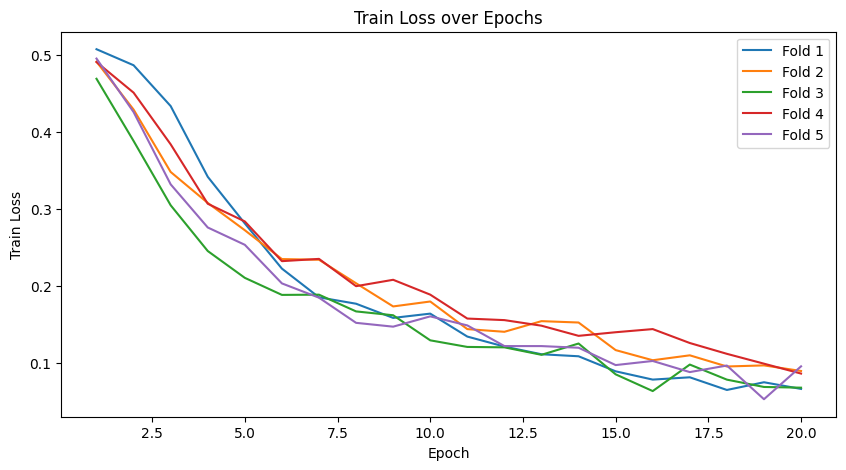

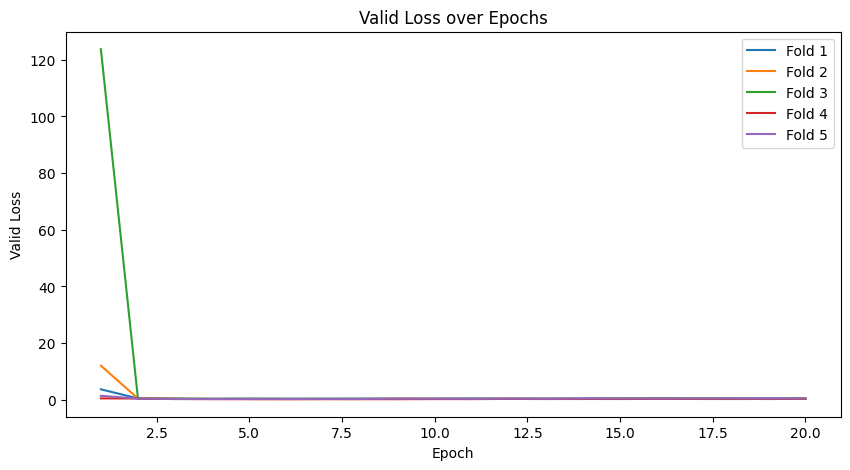

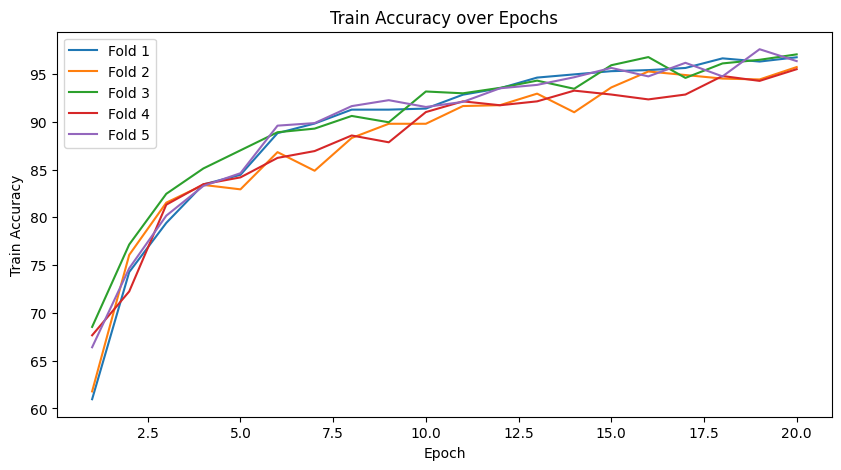

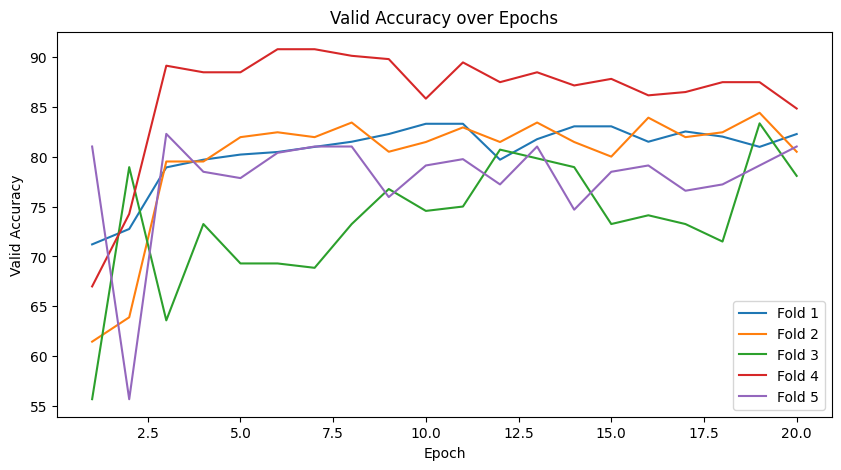

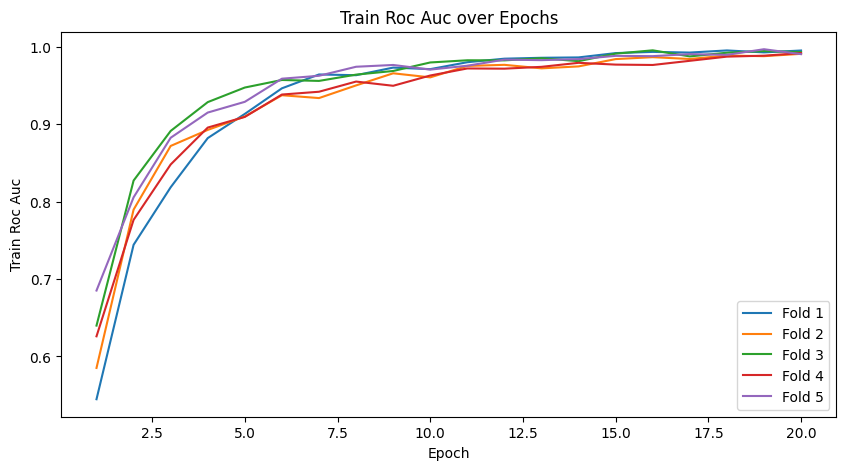

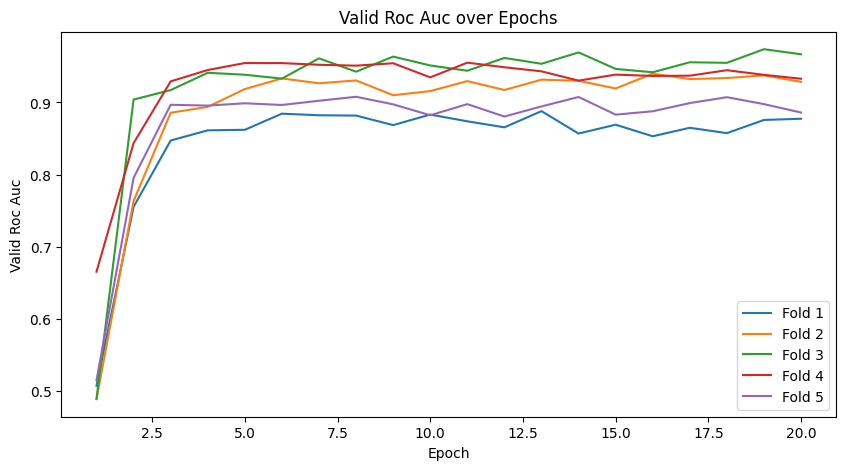

In [84]:
# Plotting function for losses and accuracies by fold
def plot_metrics(metrics, num_folds):
    metric_names = ['train_loss', 'valid_loss', 'train_accuracy', 'valid_accuracy', 'train_roc_auc', 'valid_roc_auc']
    for metric_name in metric_names:
        plt.figure(figsize=(10, 5))
        for fold in range(1, num_folds + 1):
            fold_metric = metrics[fold][metric_name]
            plt.plot(range(1, num_epochs + 1), fold_metric, label=f'Fold {fold}')
        plt.title(f'{metric_name.replace("_", " ").title()} over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel(metric_name.replace('_', ' ').title())
        plt.legend()
        plt.show()

# Call the plotting function
plot_metrics(metrics, num_folds)

**INFERENCE (BAG LEVEL)** 

In [85]:
from collections import defaultdict

def calculate_wsi_level_metrics(wsi_ids, ann_ids, ground_labels, predicted_labels):
    # Dictionary to store TP, FP, TN, FN counts per WSI and per class
    wsi_metrics = defaultdict(lambda: {"0": {"TP": 0, "FP": 0, "TN": 0, "FN": 0}, 
                                       "1": {"TP": 0, "FP": 0, "TN": 0, "FN": 0}})

    # Iterate through each annotation and count TP, FP, TN, FN per WSI and per class
    for wsi, ground, pred in zip(wsi_ids, ground_labels, predicted_labels):
        if ground == 1 and pred == 1:
            wsi_metrics[wsi]["1"]["TP"] += 1
        elif ground == 0 and pred == 1:
            wsi_metrics[wsi]["1"]["FP"] += 1
            wsi_metrics[wsi]["0"]["FN"] += 1
        elif ground == 0 and pred == 0:
            wsi_metrics[wsi]["0"]["TP"] += 1
        elif ground == 1 and pred == 0:
            wsi_metrics[wsi]["1"]["FN"] += 1
            wsi_metrics[wsi]["0"]["FP"] += 1

    # Calculate accuracy for class 1 and F1 scores for each class per WSI
    wsi_scores = {}
    for wsi, metrics in wsi_metrics.items():
        # Calculate accuracy for class 1
        total_1 = metrics["1"]["TP"] + metrics["1"]["FP"] + metrics["1"]["TN"] + metrics["1"]["FN"]
        accuracy_1 = ((metrics["1"]["TP"] + metrics["1"]["TN"]) / total_1) * 100 if total_1 > 0 else 0

        # Calculate F1 scores for both classes
        f1_scores = {}
        for class_label in ["0", "1"]:
            tp, fp, tn, fn = metrics[class_label]["TP"], metrics[class_label]["FP"], metrics[class_label]["TN"], metrics[class_label]["FN"]

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1_scores[class_label] = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        wsi_scores[wsi] = (accuracy_1, f1_scores["0"], f1_scores["1"])

    for wsi, (accuracy_1, f1_0, f1_1) in wsi_scores.items():
        print(f"WSI {wsi}: Class 1 Accuracy = {accuracy_1:.2f}%, F1 Score Class 0 = {f1_0:.2f}, F1 Score Class 1 = {f1_1:.2f}")


In [86]:
# Define a new dictionary to store WSI-level metrics
wsi_level_metrics = {}

# Loop over each fold and calculate WSI-level metrics
for fold in range(1, num_folds + 1):
    # Retrieve WSI IDs, annotation IDs, true labels, and predictions for the validation data in the current fold
    wsi_ids = metrics[fold]['wsi_nos']
    ann_ids = metrics[fold]['ann_nos']
    true_labels = metrics[fold]['y_true']
    predicted_labels = metrics[fold]['y_pred']

    # Call the WSI-level metrics function
    wsi_metrics = calculate_wsi_level_metrics(wsi_ids, ann_ids, true_labels, predicted_labels)

    # Store the WSI-level metrics for the fold
    wsi_level_metrics[fold] = wsi_metrics

# Now, `wsi_level_metrics` contains the aggregated results for each fold.


WSI A01: Class 1 Accuracy = 43.62%, F1 Score Class 0 = 0.70, F1 Score Class 1 = 0.61
WSI A04: Class 1 Accuracy = 92.59%, F1 Score Class 0 = 0.68, F1 Score Class 1 = 0.96
WSI A02: Class 1 Accuracy = 77.31%, F1 Score Class 0 = 0.80, F1 Score Class 1 = 0.87
WSI A03: Class 1 Accuracy = 38.10%, F1 Score Class 0 = 0.61, F1 Score Class 1 = 0.55
WSI A06: Class 1 Accuracy = 68.29%, F1 Score Class 0 = 0.74, F1 Score Class 1 = 0.81
WSI A08: Class 1 Accuracy = 48.94%, F1 Score Class 0 = 0.84, F1 Score Class 1 = 0.66
WSI A05: Class 1 Accuracy = 79.61%, F1 Score Class 0 = 0.83, F1 Score Class 1 = 0.89
WSI A07: Class 1 Accuracy = 79.17%, F1 Score Class 0 = 0.68, F1 Score Class 1 = 0.88
WSI A09: Class 1 Accuracy = 75.32%, F1 Score Class 0 = 0.24, F1 Score Class 1 = 0.86
WSI A10: Class 1 Accuracy = 81.67%, F1 Score Class 0 = 0.77, F1 Score Class 1 = 0.90
